In [1]:
#@title Supervised Learning { display-mode: "form" }
#@markdown This praktikum re-analyses gene expression measurements of two leukemia subtypes: acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML) from ([Golub et al. 1999](https://doi.org/10.1126/science.286.5439.531)).
#@markdown AML and ALL are treated with different drugs (May 9th quiz, last question).
#@markdown Determining the leukemia subtype involves multiple tests, and an experienced hematopathologist to interpet them.
#@markdown Here we aim to use supervised learning to train a classifier and predict the leukemia subtype from a single gene expression experiment.

#@markdown The web site with the raw data referred to in ([Golub et al. 1999](https://doi.org/10.1126/science.286.5439.531)) is no longer accessible.
#@markdown Luckily, the data can be found from other sources, we will use a version included in the [CAMAN package](https://cran.r-project.org/web/packages/CAMAN/index.html).
#@markdown The current cell will set up the environment & load the gene expression measurements (`exprs`), and corresponding true labels as determined by clinical tests (`sample_labels`).

#@markdown Some code cells will contain a red question mark (❓).
#@markdown To make the most of the praktikum, try to fill in the missing code.
#@markdown Typically, this will involve copying a few lines directly from above, and replacing variables or adjusting parameters.

# Remove Colab `/content/sample_data/` directory to avoid confusion
!rm -rf sample_data

# Upgrade scikit-learn, as the default Colab version does not have `DecisionBoundaryDisplay`
!pip install pyreadr

# Download & unpack the CAMAN package
!wget -nv https://cran.r-project.org/src/contrib/CAMAN_0.77.tar.gz
!tar xvfz CAMAN_0.77.tar.gz > /dev/null

# Import modules from numpy, pandas, seaborn, sklearn
import requests
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import sklearn.inspection, sklearn.metrics, sklearn.neighbors, sklearn.svm, sklearn.pipeline, sklearn.preprocessing
import pyreadr

# Fix `RANDOM_SEED` for (partial) reproducibility
RANDOM_SEED = 4 # https://xkcd.com/221

def plot_question_mark(ax):
  ax.text(x=.5, y=.5, s='?', color='red', fontsize=64,
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

# Use g:Convert to map microarray probe identifiers to gene names
def g_convert(query, target='ENSG', organism='hsapiens', simplify=False):
  # https://biit.cs.ut.ee/gprofiler/convert
  r = requests.post(url='https://biit.cs.ut.ee/gprofiler/api/convert/convert/', json=locals())
  df = pd.DataFrame(r.json()['result'])
  return df

golubMerge = pyreadr.read_r('CAMAN/data/golubMerge.RData')
exprs = golubMerge['golubMerge.exprs']
sample_labels = golubMerge['sample.labels']
print('Loading Golub et al. 1999 data:')
print('- exprs:', exprs.shape)
print('- sample_labels:', sample_labels.shape)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 8.4 MB/s eta 0:00:00
2023-05-17 08:11:01 URL:https://cran.r-project.org/src/contrib/CAMAN_0.77.tar.gz [975637/975637] -> "CAMAN_0.77.tar.gz" [1]
Loading Golub et al. 1999 data:
- exprs: (7129, 72)
- sample_labels: (72, 1)


# 1 Data wrangling

## Expression measurements
The gene expression matrix `exprs` has 7129 rows and 72 columns. The number of columns matches the number of samples in the training set (38) plus the number of samples in the validation set (34).

In [2]:
exprs.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
AFFX-BioB-5_at,-342.0,-87.0,22.0,-243.0,-130.0,-256.0,-62.0,86.0,-146.0,-187.0,...,7.0,-213.0,-25.0,-72.0,-4.0,15.0,-318.0,-32.0,-124.0,-135.0
AFFX-BioB-M_at,-200.0,-248.0,-153.0,-218.0,-177.0,-249.0,-23.0,-36.0,-74.0,-187.0,...,-100.0,-252.0,-20.0,-139.0,-116.0,-114.0,-192.0,-49.0,-79.0,-186.0
AFFX-BioB-3_at,41.0,262.0,17.0,-163.0,-28.0,-410.0,-7.0,-141.0,170.0,312.0,...,-57.0,136.0,124.0,-1.0,-125.0,2.0,-95.0,49.0,-37.0,-70.0
AFFX-BioC-5_at,328.0,295.0,276.0,182.0,266.0,24.0,142.0,252.0,174.0,142.0,...,132.0,318.0,325.0,392.0,241.0,193.0,312.0,230.0,330.0,337.0
AFFX-BioC-3_at,-224.0,-226.0,-211.0,-289.0,-170.0,-535.0,-233.0,-201.0,-32.0,114.0,...,-377.0,-209.0,-396.0,-324.0,-191.0,-51.0,-139.0,-367.0,-188.0,-407.0


The row names look like Affymetrix probe identifiers. We will use [g:Convert](https://biit.cs.ut.ee/gprofiler/convert) to transform them to gene names. We will also aggregate the probe-level measurements by taking the average of probes mapping to the same gene. 

In [3]:
gene_conversion = g_convert(exprs.index.tolist()).query('(n_converted == 1) & (name != "None")')
gene_expression = exprs.merge(gene_conversion[['incoming', 'name']], left_index=True, right_on='incoming').drop(['incoming'], axis=1).set_index('name', drop=True).groupby('name').agg('mean')
gene_expression

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
name,,,,,,,,,,,,,,,,,,,,,
A2M,168.0,-48.0,53.0,100.0,57.0,237.0,89.0,93.0,-19.0,54.0,...,9.0,299.0,129.0,-41.0,-2.0,9.0,266.0,105.0,30.0,97.0
AADAC,91.0,-39.0,17.0,8.0,53.0,-14.0,36.0,26.0,93.0,110.0,...,48.0,173.0,187.0,212.0,228.0,43.0,0.0,194.0,276.0,363.0
AAMP,1289.0,1288.0,876.0,1162.0,1770.0,2071.0,903.0,951.0,889.0,855.0,...,1113.0,1565.0,1436.0,1676.0,1309.0,695.0,1381.0,1748.0,1467.0,1802.0
AANAT,808.0,1515.0,1061.0,552.0,1486.0,2306.0,793.0,1139.0,936.0,979.0,...,1457.0,1155.0,2362.0,2585.0,1547.0,514.0,1272.0,1765.0,2109.0,3011.0
AARS1,975.0,1081.0,356.0,1273.0,1380.0,1247.0,1100.0,932.0,1042.0,1006.0,...,836.0,640.0,348.0,533.0,1028.0,376.0,553.0,296.0,554.0,-16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPBP,-347.0,-174.0,-22.0,-161.0,-84.0,-153.0,-61.0,31.0,-78.0,-178.0,...,-286.0,-305.0,-216.0,-67.0,-82.0,-69.0,-125.0,-151.0,-140.0,-193.0
ZRSR2,-668.0,-1521.0,-391.0,-470.0,-621.0,-1568.0,-186.0,-435.0,-259.0,-559.0,...,-1046.0,-1121.0,-784.0,-543.0,-940.0,-388.0,-1189.0,-1188.0,-1022.0,-1208.0
ZSCAN26,82.0,108.0,-1.0,-10.0,138.0,390.0,97.0,55.0,45.0,27.0,...,153.0,56.0,24.0,117.0,121.0,59.0,81.0,39.0,91.0,23.0


How many gene-level measurements do we get? How does the number compare to what was reported in the original study (n=6817)? If the numbers are different, why?

## Sample labels
According to the paper, the training set has 38 samples (27 ALL, 11 AML) and the validation set has 34 samples (20 ALL, 14 ALL; footnote 23). The total number of ALL and AML samples from the paper seems to match the contents of `sample_labels`.

In [4]:
sample_labels.value_counts()

sample.labels
ALL              47
AML              25
dtype: int64

However, there's no explicit information on whether a sample belongs to the training set or the validation set. We first try using the first 38 samples as the training set (`samples_train`), and the remaining 34 samples as the validation set (`samples_valid`). This does not reproduce the number of ALL/AML samples in the training/validation sets as reported in the paper. Can you find an alternative partitioning that recapitulates ALL/AML counts? Look at the contents of `sample_labels` for additional clues.

We then define training/validation subsets of gene expression and corresponding labels to use as input for supervised learning.

In [5]:
#❓: Modify lines below to reproduce the train/validation sets from the original study
#samples_train = range(0, 38)
#samples_valid = range(38, len(sample_labels))

#✅: first 34 rows are the validation set, last 38 rows are the training set
samples_train = range(34, len(sample_labels))
samples_valid = range(0, 34)

# Sample labels for training & validation sets (check counts)
labels_train = sample_labels.loc[samples_train]
labels_valid = sample_labels.loc[samples_valid]
print('Labels, training:', labels_train.value_counts())
print('Labels, validation:', labels_valid.value_counts())

# Gene expression for training & validation sets
expression_train = gene_expression.transpose().loc[samples_train]
expression_valid = gene_expression.transpose().loc[samples_valid]
print('Gene expression, training:', expression_train.shape)
print('Gene expression, validation:', expression_valid.shape)

# Gene expression + sample label together for traning & validation sets
# (Useful for seabron visualisation routines.)
data_train = pd.concat([expression_train, labels_train], axis=1)
data_valid = pd.concat([expression_valid, labels_valid], axis=1)

Labels, training: sample.labels
ALL              27
AML              11
dtype: int64
Labels, validation: sample.labels
ALL              20
AML              14
dtype: int64
Gene expression, training: (38, 5436)
Gene expression, validation: (34, 5436)


# 2 Single-feature classification

The study notes that ALL/AML subtypes were initially motivated by differences in periodic acid-Schiff (PAS) staining, and levels of myeloperoxidase. Could we differentiate between ALL/AML by using known biologically relevant genes?
PAS staining in cancer cells detects excess glycogen, we arbitrarily pick HK2 as a PAS proxy. Similarly, we also look at expression levels for myeloperoxidase (MPO).

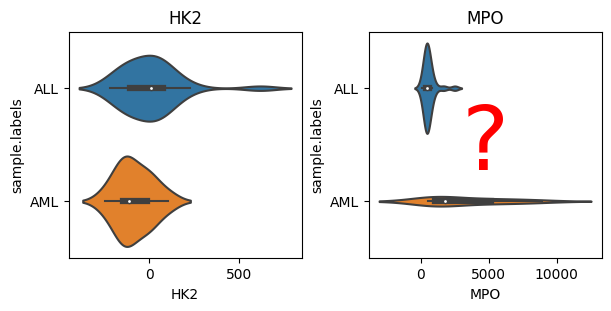

In [6]:
gene1, gene2 = 'HK2', 'MPO'

# Plot with two sub-panels
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), constrained_layout=True)

# Violin plot for GCK glucokinase
ax1.set_title(gene1)
sns.violinplot(data=data_train, x=gene1, y='sample.labels', ax=ax1);

#❓: Add violin plot for MPO myeloperoxidase
plot_question_mark(ax2)
#✅:
ax2.set_title(gene2)
sns.violinplot(data=data_train, x=gene2, y='sample.labels', ax=ax2);

Gene expression looks different for both subgroups, let's look at the corresponding ROC curves and AUC scores.

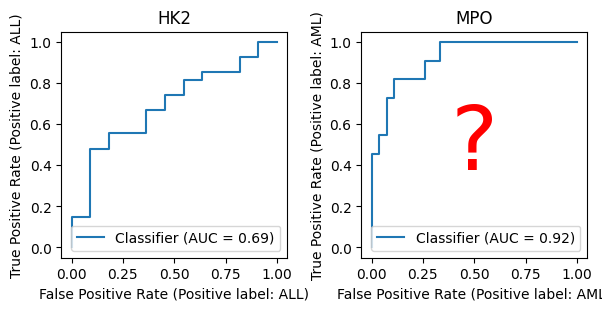

In [7]:
# Plot with two sub-panels
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), constrained_layout=True)

# Add ROC curve for GCK
ax1.set_title(gene1)
ax1.set_aspect('equal')
sklearn.metrics.RocCurveDisplay.from_predictions(y_true=labels_train, y_pred=expression_train[gene1], pos_label='ALL', ax=ax1);

#❓: Add ROC curve for MPO
plot_question_mark(ax2)
#✅:
ax2.set_title(gene2)
ax2.set_aspect('equal')
sklearn.metrics.RocCurveDisplay.from_predictions(y_true=labels_train, y_pred=expression_train[gene2], pos_label='AML', ax=ax2);

# 3 Visualising classifier output
Both HK2 and MPO expression are different in ALL/AML, but neither alone would be sufficient for a clinically useful classification. We'll try to combine the two genes using a supervised learning method. Specifically, we will try a linear Support Vector Machine (SVM) and k-nearest neighbours classifier (KNN), as discussed in [this article](https://www.nature.com/articles/nmeth.4551) from the [Points of Significance series](https://www.nature.com/collections/qghhqm/pointsofsignificance).

First, we train an SVM on HK2 and MPO expression, and visualise the corresponding decision surface and ROC curve for the training data.

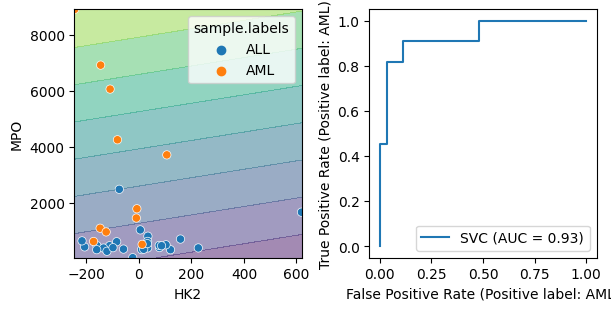

In [8]:
# Train SVM on training data
svm = sklearn.svm.SVC(kernel='linear', random_state=RANDOM_SEED)
svm.fit(X=expression_train[[gene1, gene2]], y=np.ravel(labels_train))

# Plot with two sub-panels
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), constrained_layout=True)

# Left: decision boundary with training data
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=svm, X=expression_train[[gene1, gene2]], alpha=0.5, ax=ax1);
sns.scatterplot(data=data_train, x=gene1, y=gene2, hue='sample.labels', ax=ax1);

# Right: ROC curve (training data)
sklearn.metrics.RocCurveDisplay.from_estimator(svm, X=expression_train[[gene1, gene2]], y=labels_train, pos_label='AML', ax=ax2);

We'll also train a KNN classifier for comparison. We have changed n_neighbors from the default value (5) to 2, leading to a very high AUC score on the training data.

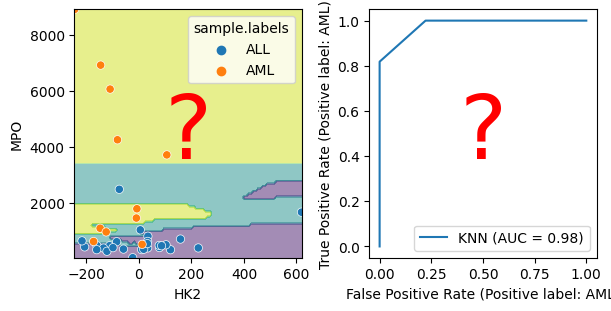

In [9]:
# Train knn on training data
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=2)
knn.fit(X=expression_train[[gene1, gene2]], y=np.ravel(labels_train))

# Plot with two sub-panels
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), constrained_layout=True)

#❓: Add decision boundary for knn 
#✅:
plot_question_mark(ax1)
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=knn, X=expression_train[[gene1, gene2]], alpha=0.5, ax=ax1);
sns.scatterplot(data=data_train, x=gene1, y=gene2, hue='sample.labels', ax=ax1);

#❓: Add ROC curve for knn
#✅:
plot_question_mark(ax2)
sklearn.metrics.RocCurveDisplay.from_estimator(knn, X=expression_train[[gene1, gene2]], y=labels_train, pos_label='AML', ax=ax2, name='KNN');

# 4 Training vs validation

We'll now look at the performance of both models on the validation data. Which classifier would you expect to generalise better (e.g. looking at the decision boundaries above)?

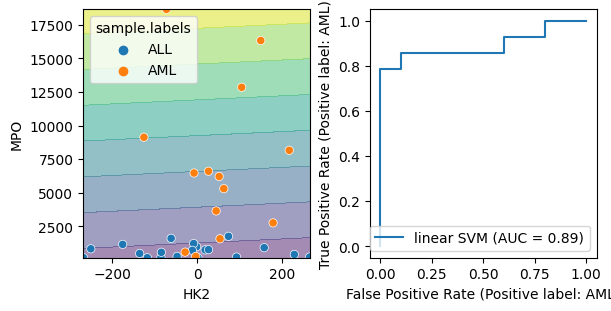

In [10]:
# Plot with two sub-panels
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), constrained_layout=True)

# Left: decision boundary with test data
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=svm, X=expression_valid[[gene1, gene2]], alpha=0.5, ax=ax1);
sns.scatterplot(data=data_valid, x=gene1, y=gene2, hue='sample.labels', ax=ax1);

# Right: ROC curve (test data)
sklearn.metrics.RocCurveDisplay.from_estimator(svm, X=expression_valid[[gene1, gene2]], y=labels_valid, pos_label='AML', ax=ax2, name='linear SVM');

How would you expect KNN to perform when changing n_neighbors back to the default value (and re-training)?

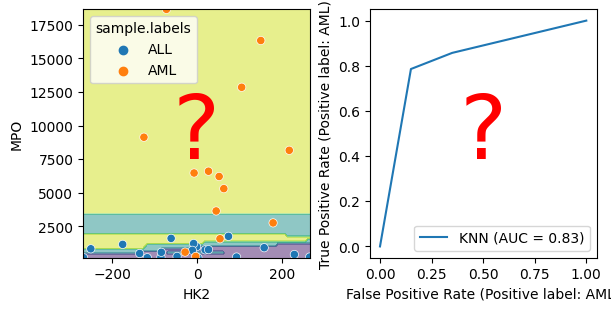

In [11]:
# Plot with two sub-panels
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), constrained_layout=True)

#❓: Add decision boundary for KNN on validation data
#✅:
plot_question_mark(ax1)
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=knn, X=expression_valid[[gene1, gene2]], alpha=0.5, ax=ax1);
sns.scatterplot(data=data_valid, x=gene1, y=gene2, hue='sample.labels', ax=ax1);

#❓: Add ROC curve for KNN on validation data
#✅:
plot_question_mark(ax2)
sklearn.metrics.RocCurveDisplay.from_estimator(knn, X=expression_valid[[gene1, gene2]], y=labels_valid, pos_label='AML', ax=ax2, name='KNN');

# 5 High-dimensional data

We now switch to working with expression data from all genes. Running an SVM with default settings reproduces the 100% accuracy reported in the study. How does this change when using a different value for the regularization parameter C?

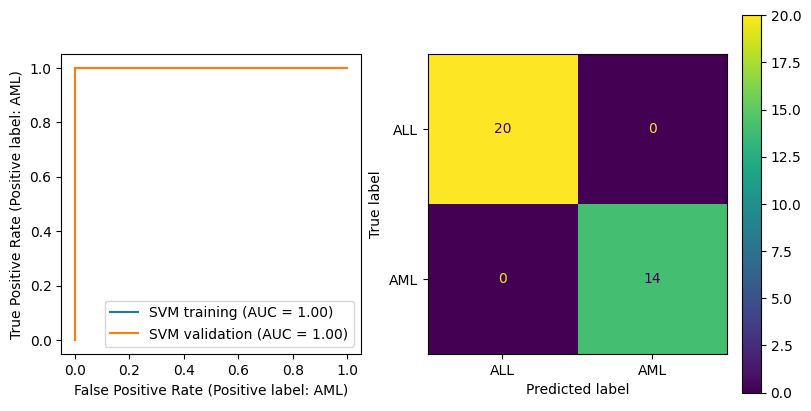

In [28]:
# Plot with two sub-panels
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

svm_full = sklearn.svm.SVC(kernel='linear', random_state=RANDOM_SEED)
svm_full.fit(X=expression_train, y=np.ravel(labels_train))

sklearn.metrics.RocCurveDisplay.from_estimator(svm_full, expression_train, labels_train, ax=ax1, name='SVM training');
sklearn.metrics.RocCurveDisplay.from_estimator(svm_full, expression_valid, labels_valid, ax=ax1, name='SVM validation');

sklearn.metrics.ConfusionMatrixDisplay.from_estimator(estimator=svm_full, X=expression_valid, y=labels_valid, ax=ax2);

How does a KNN classifier perform when trained on all genes? Feel free to try out different values for n_neighbors, like for the regularization parameter C for the SVM above. Can you rationalise the differences between an SVM and a KNN when working with a large number of features (mentioned in [this article](https://www.nature.com/articles/nmeth.4551))?

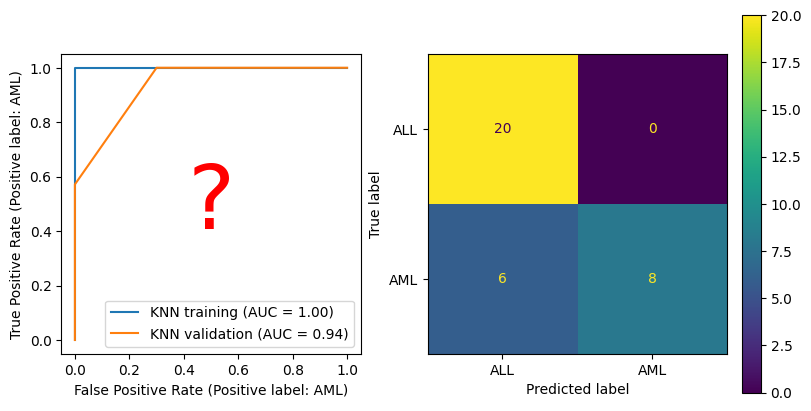

In [25]:
# Plot with two sub-panels
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

#❓: Train a KNN on the full data set
#
knn_full = sklearn.neighbors.KNeighborsClassifier(n_neighbors=2)
knn_full.fit(X=expression_train, y=np.ravel(labels_train))

#❓: Plot ROC on train & validation data
#✅:
plot_question_mark(ax1)
sklearn.metrics.RocCurveDisplay.from_estimator(knn_full, expression_train, labels_train, ax=ax1, name='KNN training');
sklearn.metrics.RocCurveDisplay.from_estimator(knn_full, expression_valid, labels_valid, ax=ax1, name='KNN validation');

#❓: Plot confusion matrix on validation data
#✅:
#plot_question_mark(ax2)
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(estimator=knn_full, X=expression_valid, y=labels_valid, ax=ax2);

# 6 Model interpretability

Many machine learning algorithms are able to estimate the contribution of each feature towards making correct classifications. In the original study, feature importance was quantified by correlating the expression of an individual gene to the sample labels. For a linear SVM, feature importance is often quantified with the coefficients of the separating hyperplane. The code below extracts the hyperplane weights (one per gene), normalises and ranks them.

In [14]:
feature_importance = expression_train.transpose()
feature_importance.insert(loc=0, column='SVM_importance', value=svm_full.coef_[0] / max(abs(svm_full.coef_[0])))
feature_importance.insert(loc=1, column='SVM_importance_pct', value=feature_importance['SVM_importance'].abs().rank(ascending=True, pct=True))
feature_importance = feature_importance.sort_values('SVM_importance_pct', ascending=False)
feature_importance.head(10)

,SVM_importance,SVM_importance_pct,34,35,36,37,38,39,40,41,...,62,63,64,65,66,67,68,69,70,71
name,,,,,,,,,,,,,,,,,,,,,
HBD,1.000000,1.000000,8860.5,4956.0,14114.0,12103.5,1838.5,3890.5,21509.0,4501.5,...,33695.0,9659.0,9203.5,8707.5,8114.5,8304.0,7575.0,10463.5,8996.5,1841.5
HBG2,0.985668,0.999816,7.0,1405.0,-33.0,6418.0,2139.0,-74.0,2377.0,3817.0,...,11527.0,782.0,1729.0,24744.0,3074.0,6879.0,989.0,1050.0,2964.0,18773.0
VIM,0.921783,0.999632,15009.0,13566.0,18957.0,16547.0,18660.0,14522.0,9147.0,17979.0,...,11145.0,25528.0,20254.0,7075.0,18421.0,18508.0,21857.0,20540.0,20758.0,20927.0
HBA2,0.894255,0.999448,8656.0,13285.0,15704.0,15691.0,3390.0,3085.0,23015.0,17601.0,...,29588.0,9547.0,6839.0,9211.0,14629.0,17503.0,12593.0,9554.0,15235.0,11886.0
TMSB4X,-0.884547,0.999264,14223.0,17650.0,21798.0,15790.0,15470.0,29496.0,18805.0,17175.0,...,13424.0,17332.0,14387.0,15140.0,11444.0,10319.0,16802.0,14026.0,15939.0,17207.0
CST3,0.845362,0.999080,303.0,1358.0,254.0,-304.0,-86.0,1168.0,-233.0,-247.0,...,1481.0,17863.0,13296.0,1661.0,1073.0,6962.0,14555.0,7238.0,12339.0,3654.0
CXCL8,0.759475,0.998896,312.5,3703.5,138.0,119.5,115.5,119.0,133.0,218.0,...,85.5,14269.5,16170.0,7557.5,12839.0,2378.5,4738.5,1392.0,9911.5,17161.5
FTL,0.757924,0.998712,5418.0,17348.0,6156.0,7070.0,9017.0,6221.0,4746.0,7881.0,...,7855.0,24521.0,21277.0,20124.0,16705.0,11012.0,18372.0,12276.0,19173.0,21498.0
CXCR4,-0.736449,0.998528,9144.0,4090.0,3192.0,4750.0,7453.0,1897.0,7593.0,13214.0,...,216.0,4451.0,1221.0,1294.0,6127.0,1842.0,1425.0,499.0,1833.0,2395.0


The two tables below show the top 5 ALL-enriched, and AML-enriched genes from Figure 3B of the original study (using updated gene names). Can you discuss the agreement between 

Conversely, can you find any additional evidence for the top SVM-supported genes in ALL or AML, either from the original study or from additional literature?

In [18]:
all_genes = [
  'MYB', # C-myb
  'PSMA6', # Proteasome iota
  'CD79A', # MB-1
  'CCND3', # Cyclin D3
  'MYL6B', # Myosin light chain
]
feature_importance.query('name in @all_genes')

,SVM_importance,SVM_importance_pct,34,35,36,37,38,39,40,41,...,62,63,64,65,66,67,68,69,70,71
name,,,,,,,,,,,,,,,,,,,,,
CD79A,-0.542352,0.995585,9326.0,895.0,628.0,5314.0,5354.0,282.0,5146.0,4048.0,...,654.0,-14.0,218.0,251.0,-2.0,412.0,343.0,272.0,306.0,19.0
CCND3,-0.409656,0.993561,4778.0,2700.0,4926.0,5403.0,3440.0,3179.0,3978.0,3293.0,...,165.0,1309.0,852.0,1484.0,1283.0,1525.0,811.0,1032.0,1024.0,1827.0
PSMA6,-0.380115,0.991170,3016.0,3424.0,7724.0,3821.0,5216.0,4194.0,5528.0,2073.0,...,490.0,1648.0,528.0,99.0,1203.0,1561.0,1628.0,1784.0,1214.0,1583.0
MYB,-0.209737,0.975166,1745.0,624.5,2520.5,2867.0,1859.5,1738.0,2010.5,2547.0,...,534.5,349.5,188.0,475.5,494.0,712.5,338.5,309.0,634.0,309.0
MYL6B,-0.041126,0.839956,601.0,435.0,547.0,472.0,661.0,337.0,309.0,263.0,...,19.0,88.0,139.0,75.0,300.0,237.0,100.0,192.0,339.0,59.0


In [17]:
aml_genes = [
  'FAH', # Fumarylacetoacetate
  'ZYX', # Zyxin
  'LTC4S', # LTC4 synthase
  'LYN', # LYN
  'HOXA9', #HoxA9
]
#❓: Show SVM weights for top AML genes